<a href="https://colab.research.google.com/github/sergioGarcia91/BucaramangaSeismicNest_ML/blob/main/ML_SismosNido_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was created as part of the revision process to apply SHAP (https://shap.readthedocs.io) for interpreting the contribution of input features in neural network models, specifically using scikit-learn's `MLPClassifier`.

https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html


# Start

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install shap

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import shap

from sklearn.neural_network import MLPClassifier # Para la Red Neuronal
from joblib import dump, load # guardar el modelo
from datetime import datetime, timedelta


In [4]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Figuras_shap/'

# Change the font type

In [5]:
import matplotlib as mpl
import matplotlib.font_manager as fm

In [6]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-07-01 13:30:45--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-07-01 13:30:45--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf.3’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.06s   

2025-07-01 13:30:45 (13.6 MB/s) - ‘Times New Roman.ttf.3’ saved [834452/834452]



In [7]:
# Ruta a la fuente personalizada
font_path = 'Times New Roman.ttf'

# Añadir la fuente al administrador de fuentes de Matplotlib
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Nombre de la fuente para usar en rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

# SHAP

In [8]:
# best 10 AUC
ordenModelos = ['/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v6/2009_30dias_boots_hl_420_210_105_53_27_5_int0_scr0.997.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v4/2009_30dias_hl_420_5_int0_scr0.998.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v4/2009_30dias_hl_2000_5_int1_scr1.0.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v4/2009_6meses_hl_210_5_int0_scr1.0.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v6/2009_30dias_boots_hl_1500_5_int0_scr1.0.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v6/2009_30dias_boots_hl_420_5_int0_scr1.0.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v4/2009_30dias_hl_1500_5_int0_scr1.0.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v6/2009_6meses_hl_1500_750_375_188_94_5_int0_scr0.996.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v6/2009_30dias_boots_hl_2000_5_int0_scr0.999.joblib',
                '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v6/2009_6meses_hl_210_105_53_27_13_5_int0_scr1.0.joblib']

# label
labelModel = ['Mod 7',
              'Mod 15',
              'Mod 32',
              'Mod 41',
              'Mod 26',
              'Mod 13',
              'Mod 47',
              'Mod 12',
              'Mod 25',
              'Mod 24']


A subset of 200 training samples will be used for each model to evaluate the influence of the input features, along with 100 test samples. Both datasets are balanced, with half of the instances belonging to class 0 and the other half to class 1.

Reference examples:

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html


https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


------------------------------
Mod 25
Train shape:  (4719, 210)
Test shape:  (784, 210)
Y test sum:  118.0
30
['-29D Ml[2.5-3.0]', '-29D Ml[3.0-3.5]', '-29D Ml[3.5-4.0]', '-29D Ml[4.0-4.5]', '-29D Ml[4.5-5.0]', '-29D Ml[5.0-5.5]', '-29D Ml[>=5.5]', '-28D Ml[2.5-3.0]', '-28D Ml[3.0-3.5]', '-28D Ml[3.5-4.0]', '-28D Ml[4.0-4.5]', '-28D Ml[4.5-5.0]', '-28D Ml[5.0-5.5]', '-28D Ml[>=5.5]', '-27D Ml[2.5-3.0]', '-27D Ml[3.0-3.5]', '-27D Ml[3.5-4.0]', '-27D Ml[4.0-4.5]', '-27D Ml[4.5-5.0]', '-27D Ml[5.0-5.5]', '-27D Ml[>=5.5]', '-26D Ml[2.5-3.0]', '-26D Ml[3.0-3.5]', '-26D Ml[3.5-4.0]', '-26D Ml[4.0-4.5]', '-26D Ml[4.5-5.0]', '-26D Ml[5.0-5.5]', '-26D Ml[>=5.5]', '-25D Ml[2.5-3.0]', '-25D Ml[3.0-3.5]', '-25D Ml[3.5-4.0]', '-25D Ml[4.0-4.5]', '-25D Ml[4.5-5.0]', '-25D Ml[5.0-5.5]', '-25D Ml[>=5.5]', '-24D Ml[2.5-3.0]', '-24D Ml[3.0-3.5]', '-24D Ml[3.5-4.0]', '-24D Ml[4.0-4.5]', '-24D Ml[4.5-5.0]', '-24D Ml[5.0-5.5]', '-24D Ml[>=5.5]', '-23D Ml[2.5-3.0]', '-23D Ml[3.0-3.5]', '-23D Ml[3.5-4.0]', '

  0%|          | 0/100 [00:00<?, ?it/s]

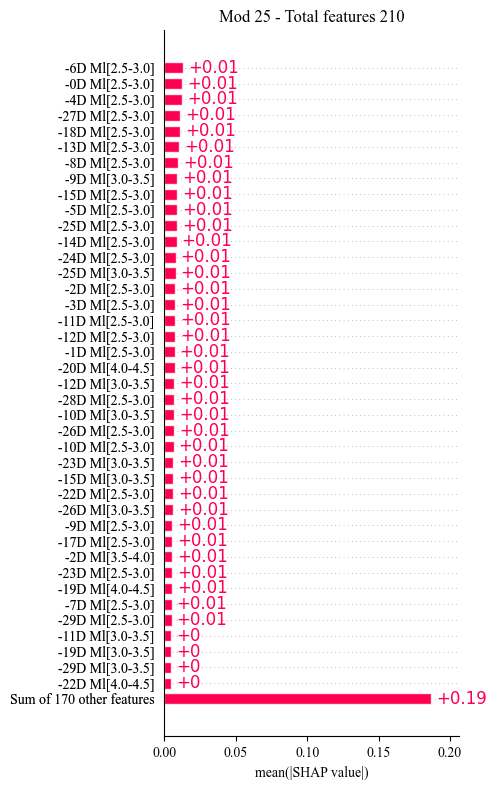

------------------------------
------------------------------


------------------------------
Mod 24
Train shape:  (4569, 1260)
Test shape:  (784, 1260)
Y test sum:  118.0
180
['-179D Ml[2.5-3.0]', '-179D Ml[3.0-3.5]', '-179D Ml[3.5-4.0]', '-179D Ml[4.0-4.5]', '-179D Ml[4.5-5.0]', '-179D Ml[5.0-5.5]', '-179D Ml[>=5.5]', '-178D Ml[2.5-3.0]', '-178D Ml[3.0-3.5]', '-178D Ml[3.5-4.0]', '-178D Ml[4.0-4.5]', '-178D Ml[4.5-5.0]', '-178D Ml[5.0-5.5]', '-178D Ml[>=5.5]', '-177D Ml[2.5-3.0]', '-177D Ml[3.0-3.5]', '-177D Ml[3.5-4.0]', '-177D Ml[4.0-4.5]', '-177D Ml[4.5-5.0]', '-177D Ml[5.0-5.5]', '-177D Ml[>=5.5]', '-176D Ml[2.5-3.0]', '-176D Ml[3.0-3.5]', '-176D Ml[3.5-4.0]', '-176D Ml[4.0-4.5]', '-176D Ml[4.5-5.0]', '-176D Ml[5.0-5.5]', '-176D Ml[>=5.5]', '-175D Ml[2.5-3.0]', '-175D Ml[3.0-3.5]', '-175D Ml[3.5-4.0]', '-175D Ml[4.0-4.5]', '-175D Ml[4.5-5.0]', '-175D Ml[5.0-5.5]', '-175D Ml[>=5.5]', '-174D Ml[2.5-3.0]', '-174D Ml[3.0-3.5]', '-174D Ml[3.5-4.0]', '-174D Ml[4.0-4.5]', '-174D Ml[4.5

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


New shape Train:  (200, 1260)
New shape Test:  (100, 1260)


  0%|          | 0/100 [00:00<?, ?it/s]

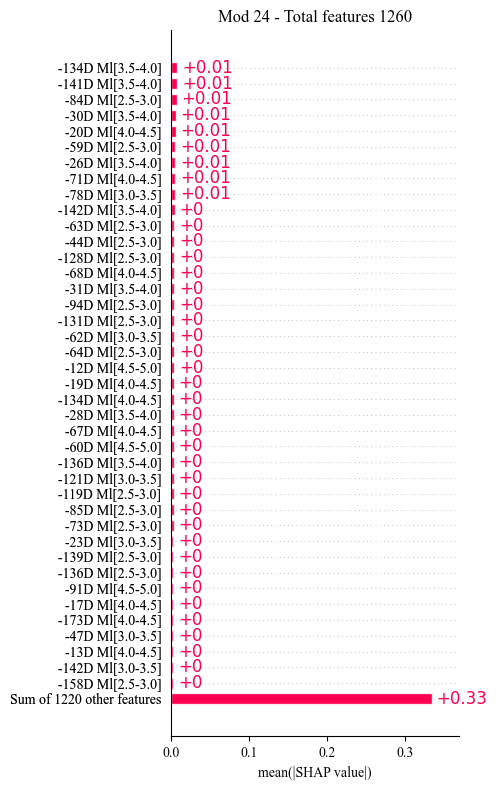

------------------------------
------------------------------




In [9]:
inicial_model = 8

for modelo, labelModelo in zip(ordenModelos[inicial_model:], labelModel[inicial_model:]):
  if 'joblib' in modelo:
    if '6meses' in modelo:
      dias_Considerar = 180
      X2023 = np.loadtxt(pathDatos+'2009_6meses_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009_6meses_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009_6meses_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009_6meses_y2021.txt')

    if '12meses' in modelo:
      dias_Considerar = 365
      X2023 = np.loadtxt(pathDatos+'2009_12meses_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009_12meses_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009_12meses_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009_12meses_y2021.txt')

    if '30dias' in modelo:
      dias_Considerar = 30
      X2023 = np.loadtxt(pathDatos+'2009_30dias_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009_30dias_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009_30dias_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009_30dias_y2021.txt')

    print(10*'---')
    print(labelModelo)
    print('Train shape: ', X2022.shape)
    print('Test shape: ', X2023.shape)
    print('Y test sum: ', y2023.sum())

    # labels days
    days_labels = []
    days = int(X2022.shape[1]/7)
    print(days)
    for day in range(days-1, -1, -1):
      for ml in ['2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '>=5.5']:
        label = f'-{day}D Ml[{ml}]'
        days_labels.append(label)
    print(days_labels)
    print(len(days_labels)==X2022.shape[1])


    modelo_P = load(modelo)
    n_features = X2022.shape[1]

    # 2023
    #predichosModelo = modelo_P.predict(X2023)
    #predProb_Modelo = modelo_P.predict_proba(X2023)[:,1]
    # 1994-2023
    #predichosModelo_2022 = modelo_P.predict(X2022)
    #predProb_Modelo_2022 = modelo_P.predict_proba(X2022)[:,1]

    #nMin = dias_Considerar - 1


    #reducir las muestras a solo 200 TRAIN
    samples = int(200 / 2) # la mitad va ser 0 y la otra 1 # 80 mod 12 24
    filter_0 = y2022 == 0
    filter_1 = y2022 == 1
    X2022_0 = X2022[filter_0, :].copy()
    X2022_1 = X2022[filter_1, :].copy()

    increse = int(X2022_0.shape[0]/samples)
    X2022_0 = X2022_0[::increse, :]
    X2022_0 = X2022_0[:samples, :]
    increse = int(X2022_1.shape[0]/samples)
    X2022_1 = X2022_1[::increse, :]
    X2022_1 = X2022_1[:samples, :]
    X2022 = np.concatenate((X2022_0, X2022_1), axis=0)
    print('New shape Train: ', X2022.shape)

    #reducir las muestras a solo 100 TEST
    samples = int(100 / 2 ) # 30 para el mod 12 24
    filter_0 = y2023 == 0
    filter_1 = y2023 == 1
    X2023_0 = X2023[filter_0, :].copy()
    X2023_1 = X2023[filter_1, :].copy()

    increse = int(X2023_0.shape[0]/samples)
    X2023_0 = X2023_0[::increse, :]
    X2023_0 = X2023_0[:samples, :]
    increse = int(X2023_1.shape[0]/samples)
    X2023_1 = X2023_1[::increse, :]
    X2023_1 = X2023_1[:samples, :]
    X2023 = np.concatenate((X2023_0, X2023_1), axis=0)
    print('New shape Test: ', X2023.shape)



    # Crear el explainer de SHAP
    explainer = shap.KernelExplainer(modelo_P.predict_proba, # Modelo o funcion que predice
                                     X2022,# Los datos de fondo que se usaran para reemplazar en la explicacion
                                     feature_names=days_labels) # Las etiquetas de las features

    #shap_values = explainer.shap_values(X2023)
    shap_values = explainer(X2023) # Para poder hacer el de barras

    fig, ax = plt.subplots(figsize=(5, 8))
    # Graficar SHAP
    shap.plots.bar(shap_values[:, :, 1], max_display=41, ax=ax, show=False)
    # Título del gráfico
    ax.set_title(f'{labelModelo} - Total features {n_features}', fontsize=12, fontname='Times New Roman')
    # Cambiar fuente de las etiquetas de los ejes X e Y
    for label in ax.get_xticklabels():
        label.set_fontname('Times New Roman')
        label.set_fontsize(10)
    for label in ax.get_yticklabels():
        label.set_fontname('Times New Roman')
        label.set_fontsize(10)
    # Ajustar el label del eje X
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, fontname='Times New Roman')
    plt.tight_layout()
    # Guardar la figura
    plt.savefig((pathSaveFiguras + f'SHAP_{labelModelo}.png'),
                format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print(10*'---')
    print(10*'---')
    print('\n') #

# End